<a href="https://colab.research.google.com/github/dostirathi031/alz_Detection/blob/main/vgg19_final_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
import os
import pandas as pd
import numpy as np
import keras
import warnings

warnings.filterwarnings(action="ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import backend as K

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler


In [ ]:
MildDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/VeryMildDemented'

filepaths = []
labels = []
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Alzheimer_data = pd.concat([Fseries, Lseries], axis=1)
Alzheimer_df = pd.DataFrame(Alzheimer_data)
print(Alzheimer_df.head())
print(Alzheimer_df["labels"].value_counts())

train_images, test_images = train_test_split(
    Alzheimer_df, test_size=0.3, random_state=42, stratify=Alzheimer_df['labels']
)
train_set, val_set = train_test_split(
    train_images, test_size=0.2, random_state=42, stratify=train_images['labels']
)

print(train_set.shape)
print(test_images.shape)
print(val_set.shape)


                                           filepaths         labels
0  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
1  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
2  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
3  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
4  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
labels
Non Demented         9600
Mild Demented        8960
Very MildDemented    8960
Moderate Demented    6464
Name: count, dtype: int64
(19030, 2)
(10196, 2)
(4758, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
train_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    rotation_range=40,  # Increased range
    width_shift_range=0.3,  # Increased range
    height_shift_range=0.3,  # Increased range
    shear_range=0.3,  # Increased range
    zoom_range=0.3,  # Increased range
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]  # Added brightness adjustment
)

train = image_gen.flow_from_dataframe(dataframe=train_set, x_col="filepaths", y_col="labels",
                                      target_size=(244, 244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=32,
                                      shuffle=True
                                     )
test = image_gen.flow_from_dataframe(dataframe=test_images, x_col="filepaths", y_col="labels",
                                     target_size=(244, 244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle=False
                                    )
val = image_gen.flow_from_dataframe(dataframe=val_set, x_col="filepaths", y_col="labels",
                                    target_size=(244, 244),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

classes = list(train.class_indices.keys())
print(classes)


Found 19030 validated image filenames belonging to 4 classes.
Found 10196 validated image filenames belonging to 4 classes.
Found 4758 validated image filenames belonging to 4 classes.
['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']


In [ ]:
# Image shape should be 224x224 for VGG19
img_shape = (244, 244, 3)

base_model = tf.keras.applications.VGG19(
    include_top=False, weights="imagenet", input_shape=(244, 244, 3), pooling='max'
)
# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-10:]:  # Adjust as needed
    layer.trainable = True


# Create the new model
VGG19_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

VGG19_model.compile(Adamax(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary to confirm the changes
VGG19_model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 512)                 │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,090,564 (76.64 MB)

 Trainable params: 16,584,836 (63.27 MB)

 Non-trainable params: 3,505,728 (13.37 MB)

In [ ]:
def lr_schedule(epoch):
    return 0.001 * (0.9 ** epoch)

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Set a higher patience value to allow the model to train more
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

In [ ]:
# Train the model for more epochs
history = VGG19_model.fit(train, epochs=10, validation_data=val, callbacks=[early_stopping])

Epoch 1/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 154s 229ms/step - accuracy: 0.4611 - loss: 1.1289 - val_accuracy: 0.7318 - val_loss: 0.5983
Epoch 2/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 115s 192ms/step - accuracy: 0.7240 - loss: 0.6077 - val_accuracy: 0.8541 - val_loss: 0.3493
Epoch 3/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 115s 192ms/step - accuracy: 0.8622 - loss: 0.3289 - val_accuracy: 0.9306 - val_loss: 0.1812
Epoch 4/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 115s 192ms/step - accuracy: 0.9310 - loss: 0.1822 - val_accuracy: 0.9651 - val_loss: 0.0879
Epoch 5/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 115s 192ms/step - accuracy: 0.9707 - loss: 0.0875 - val_accuracy: 0.9813 - val_loss: 0.0554
Epoch 6/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 115s 192ms/step - accuracy: 0.9839 - loss: 0.0500 - val_accuracy: 0.9723 - val_loss: 0.0744
Epoch 7/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 115s 192ms/step - accuracy: 0.9869 - loss: 0.0358 - val_accuracy: 0.9830 - val_loss: 0.0494
Epoch 8/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 115s 192ms/step - accuracy: 0.9921 -

In [ ]:
VGG19_model.evaluate(test, verbose=1)

train_loss, train_accuracy = VGG19_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

train_loss, train_accuracy = VGG19_model.evaluate(val)
print(f'\nvalidation loss: {train_loss:.2f}')
print(f'Validation Accuracy: {train_accuracy*100:.2f} %')

train_loss, train_accuracy = VGG19_model.evaluate(test)
print(f'\ntest loss: {train_loss:.2f}')
print(f'Test Accuracy: {train_accuracy*100:.2f} %')


319/319 ━━━━━━━━━━━━━━━━━━━━ 55s 171ms/step - accuracy: 0.9923 - loss: 0.0230
595/595 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - accuracy: 0.9998 - loss: 9.0169e-04

Train loss: 0.00
Train Accuracy: 99.97 %
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.9930 - loss: 0.0226

validation loss: 0.02
Validation Accuracy: 99.22 %
319/319 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - accuracy: 0.9923 - loss: 0.0230

test loss: 0.02
Test Accuracy: 99.30 %


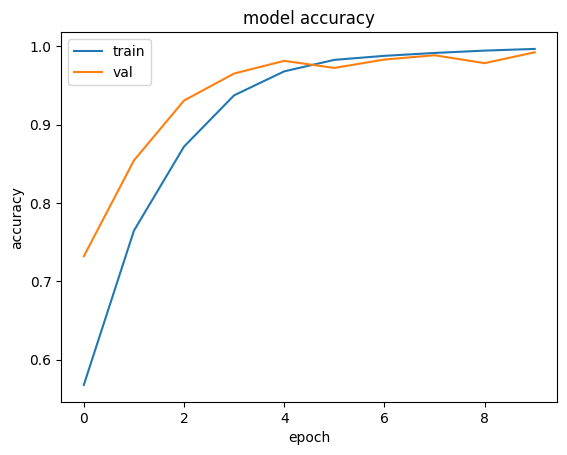

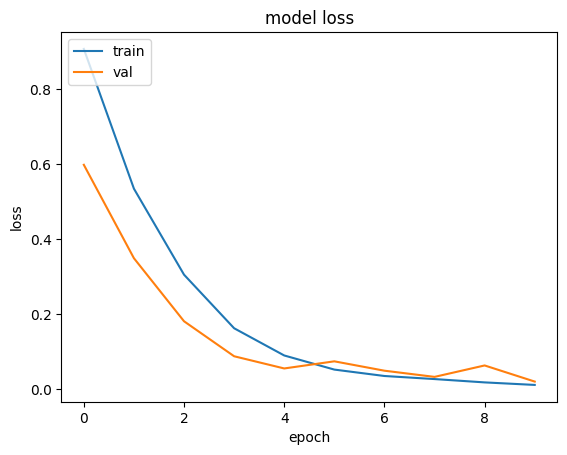

In [ ]:
# Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


319/319 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step
                   precision    recall  f1-score   support

    Mild Demented       0.99      1.00      0.99      2688
Moderate Demented       1.00      1.00      1.00      1940
     Non Demented       0.99      0.99      0.99      2880
Very MildDemented       0.99      0.98      0.99      2688

         accuracy                           0.99     10196
        macro avg       0.99      0.99      0.99     10196
     weighted avg       0.99      0.99      0.99     10196

Accuracy of the Model: 99.3%


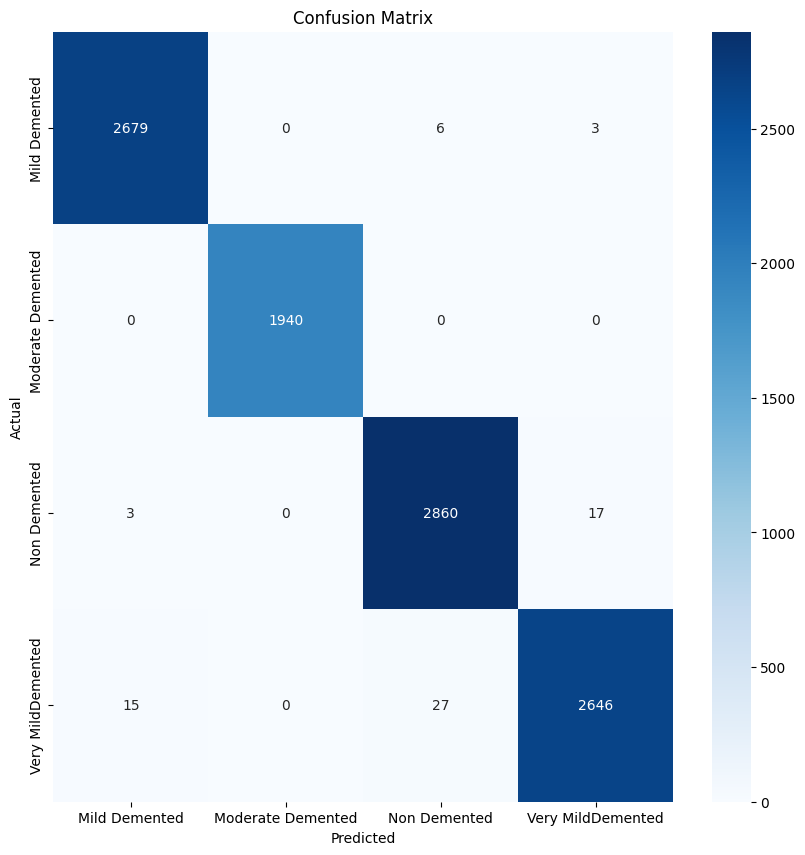

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

y_test = test_images.labels
pred = VGG19_model.predict(test)
pred = np.argmax(pred, axis=1)

# Reverse the class indices
labels = train.class_indices
labels = dict((v, k) for k, v in labels.items())
pred2 = [labels[k] for k in pred]

print(classification_report(y_test, pred2))
print("Accuracy of the Model:", "{:.1f}%".format(accuracy_score(y_test, pred2) * 100))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()


In [ ]:
# Save the trained model
VGG19_model.save('vgg19_alzheimer_model.h5')
print("Model saved successfully!")

Model saved successfully!
